# Proyecto 2
Ariela Mishaan (22052), Alina Carías (22539), Diego Soto (22737), Ignacio Méndez (22613) y Marcos Díaz

## Librerias

In [5]:
import os
import gc
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from sklearn.preprocessing import MinMaxScaler

## Carga de datos

In [6]:

def load_data(source):
    if isinstance(source, pd.DataFrame):
        data = source
    else:
        data = pd.read_parquet(source)
    if 'sequence_id' not in data.columns:
        data = data.reset_index()
    return data

def pick_sequence(data: pd.DataFrame, seq_id=None):
    if seq_id is None:
        seq_id = data["sequence_id"].iloc[0]
    seq = data[data["sequence_id"] == seq_id].reset_index(drop=True)
    return seq_id, seq


In [8]:
PARQUET_PATH = "/kaggle/input/asl-fingerspelling/train_landmarks/1019715464.parquet"
data = load_data(PARQUET_PATH)
SEQ_ID, seq = pick_sequence(data)
print("Usando SEQ_ID:", SEQ_ID, "| Frames:", len(seq))

Usando SEQ_ID: 1975433633 | Frames: 127


## Funciones para exploracion

In [19]:
# Conexiones Mediapipe 
HAND_CONNECTIONS = [
    (0,1),(1,2),(2,3),(3,4),
    (0,5),(5,6),(6,7),(7,8),
    (5,9),(9,10),(10,11),(11,12),
    (9,13),(13,14),(14,15),(15,16),
    (13,17),(17,18),(18,19),(19,20),
    (0,17)
]
POSE_CONNECTIONS = [
    (11,12),(11,13),(13,15),(12,14),(14,16),
    (11,23),(12,24),(23,24),(23,25),(24,26)
]
FACE_CONNECTIONS = [(33,133),(362,263),(61,291),(0,17),(78,308)]

N_POINTS = {"right_hand":21,"left_hand":21,"pose":33,"face":468}
CONNS = {"right_hand":HAND_CONNECTIONS,"left_hand":HAND_CONNECTIONS,
         "pose":POSE_CONNECTIONS,"face":FACE_CONNECTIONS}

COLS3 = {
    "right_hand":("x_right_hand_","y_right_hand_","z_right_hand_"),
    "left_hand": ("x_left_hand_", "y_left_hand_", "z_left_hand_"),
    "pose":      ("x_pose_",      "y_pose_",      "z_pose_"),
    "face":      ("x_face_",      "y_face_",      "z_face_"),
}
COLS2 = {
    "right_hand":("x_right_hand_","y_right_hand_"),
    "left_hand": ("x_left_hand_", "y_left_hand_"),
    "pose":      ("x_pose_","y_pose_"),
    "face":      ("x_face_","y_face_"),
}

# Extraccion
def extract_landmarks3d(row: pd.Series, part: str):
    px, py, pz = COLS3[part]; n = N_POINTS[part]
    xs, ys, zs = [], [], []
    for i in range(n):
        xs.append(row.get(f"{px}{i}", np.nan))
        ys.append(row.get(f"{py}{i}", np.nan))
        zs.append(row.get(f"{pz}{i}", np.nan))
    return np.array(xs), np.array(ys), np.array(zs)

def extract_xy(row: pd.Series, part: str, mirror_x=False):
    px, py = COLS2[part]; n = N_POINTS[part]
    xs, ys = [], []
    for i in range(n):
        x = row.get(f"{px}{i}", np.nan)
        y = row.get(f"{py}{i}", np.nan)
        if part in ("right_hand","left_hand") and mirror_x and np.isfinite(x):
            x = 1 - x
        xs.append(x); ys.append(y)
    return np.array(xs), np.array(ys)

# Validación y selección de mano 
def count_valid_xy_row(row: pd.Series, part: str, N=21):
    xs = np.array([row.get(f"x_{part}_{i}", np.nan) for i in range(N)])
    ys = np.array([row.get(f"y_{part}_{i}", np.nan) for i in range(N)])
    return int((np.isfinite(xs) & np.isfinite(ys)).sum())

def pick_hand(seq: pd.DataFrame, prefer='auto', min_valid=6):
    if prefer in ('right_hand','left_hand'):
        return prefer
    vr = sum(count_valid_xy_row(seq.iloc[i], "right_hand", 21) for i in range(len(seq)))
    vl = sum(count_valid_xy_row(seq.iloc[i], "left_hand", 21)  for i in range(len(seq)))
    return "right_hand" if vr >= vl else "left_hand"

# Graficar
def draw_connections_3d(ax, xs, ys, zs, connections, color="k", lw=1):
    for i,j in connections:
        if i < len(xs) and j < len(xs):
            if (np.isfinite(xs[i]) and np.isfinite(ys[i]) and np.isfinite(zs[i]) and
                np.isfinite(xs[j]) and np.isfinite(ys[j]) and np.isfinite(zs[j])):
                ax.plot([xs[i],xs[j]],[ys[i],ys[j]],[zs[i],zs[j]], color=color, linewidth=lw)

def draw_connections_2d(ax, xs, ys, connections, color="k", lw=1):
    for i,j in connections:
        if i < len(xs) and j < len(xs):
            if np.isfinite(xs[i]) and np.isfinite(ys[i]) and np.isfinite(xs[j]) and np.isfinite(ys[j]):
                ax.plot([xs[i],xs[j]],[ys[i],ys[j]], color=color, linewidth=lw)

def plot_part_3d(ax, row, part, color, title, axis_bounds=None):
    xs, ys, zs = extract_landmarks3d(row, part)
    m = np.isfinite(xs) & np.isfinite(ys) & np.isfinite(zs)
    if m.any():
        ax.scatter(xs[m], ys[m], zs[m], c=color, s=20)
    draw_connections_3d(ax, xs, ys, zs, CONNS[part], color=color, lw=1)
    ax.set_title(title)
    if axis_bounds and part in axis_bounds:
        (xmin,xmax),(ymin,ymax),(zmin,zmax) = axis_bounds[part]
        ax.set_xlim(xmin,xmax); ax.set_ylim(ymin,ymax); ax.set_zlim(zmin,zmax)
    else:
        ax.set_xlim(0,1); ax.set_ylim(0,1); ax.set_zlim(-1,1)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

def plot_part_2d(ax, row, part, color, title, mirror_x=False):
    xs, ys = extract_xy(row, part, mirror_x=mirror_x)
    m = np.isfinite(xs) & np.isfinite(ys)
    if m.any():
        ax.scatter(xs[m], ys[m], c=color, s=12)
    draw_connections_2d(ax, xs, ys, CONNS[part], color=color, lw=1)
    ax.set_title(title)

def _rng(a):
    lo, hi = np.nanmin(a), np.nanmax(a)
    if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi: return (0,1)
    pad = 0.05*(hi-lo); return (lo-pad, hi+pad)

def compute_axis_bounds_3d(seq: pd.DataFrame, parts):
    bounds = {}
    for part in parts:
        xs_all, ys_all, zs_all = [], [], []
        for i in range(len(seq)):
            xs, ys, zs = extract_landmarks3d(seq.iloc[i], part)
            xs_all.append(xs); ys_all.append(ys); zs_all.append(zs)
        xs_all = np.concatenate(xs_all); ys_all = np.concatenate(ys_all); zs_all = np.concatenate(zs_all)
        m = np.isfinite(xs_all) & np.isfinite(ys_all) & np.isfinite(zs_all)
        if m.any():
            bounds[part] = (_rng(xs_all[m]), _rng(ys_all[m]), _rng(zs_all[m]))
    return bounds

def compute_axis_bounds_2d(seq: pd.DataFrame, parts, mirror_x=False):
    bounds = {}
    for part in parts:
        xs_all, ys_all = [], []
        for i in range(len(seq)):
            xs, ys = extract_xy(seq.iloc[i], part, mirror_x=mirror_x)
            xs_all.append(xs); ys_all.append(ys)
        xs_all = np.concatenate(xs_all); ys_all = np.concatenate(ys_all)
        m = np.isfinite(xs_all) & np.isfinite(ys_all)
        if m.any():
            bounds[part] = (_rng(xs_all[m]), _rng(ys_all[m]))
    return bounds

def set_limits_2d(ax, bounds, parts_subset, invert_y=False):
    xs, ys = [], []
    for p in parts_subset:
        if p in bounds:
            (xmin,xmax),(ymin,ymax) = bounds[p]
            xs += [xmin,xmax]; ys += [ymin,ymax]
    if xs and ys:
        ax.set_xlim(min(xs), max(xs)); ax.set_ylim(min(ys), max(ys))
    else:
        ax.set_xlim(0,1); ax.set_ylim(0,1)
    ax.set_aspect('equal', adjustable='box')
    if invert_y: ax.invert_yaxis()


## Exploración

In [33]:
data.shape

(161461, 1631)

Cada archivo de train landmark contiene alrededor de 160,000 filas que representan los frames de distintas secuencias, es decir dentro de un mismo archivo existen distintas secuencias para analizar.

In [14]:
columnas = data.columns.tolist()
print(columnas)

['sequence_id', 'frame', 'x_face_0', 'x_face_1', 'x_face_2', 'x_face_3', 'x_face_4', 'x_face_5', 'x_face_6', 'x_face_7', 'x_face_8', 'x_face_9', 'x_face_10', 'x_face_11', 'x_face_12', 'x_face_13', 'x_face_14', 'x_face_15', 'x_face_16', 'x_face_17', 'x_face_18', 'x_face_19', 'x_face_20', 'x_face_21', 'x_face_22', 'x_face_23', 'x_face_24', 'x_face_25', 'x_face_26', 'x_face_27', 'x_face_28', 'x_face_29', 'x_face_30', 'x_face_31', 'x_face_32', 'x_face_33', 'x_face_34', 'x_face_35', 'x_face_36', 'x_face_37', 'x_face_38', 'x_face_39', 'x_face_40', 'x_face_41', 'x_face_42', 'x_face_43', 'x_face_44', 'x_face_45', 'x_face_46', 'x_face_47', 'x_face_48', 'x_face_49', 'x_face_50', 'x_face_51', 'x_face_52', 'x_face_53', 'x_face_54', 'x_face_55', 'x_face_56', 'x_face_57', 'x_face_58', 'x_face_59', 'x_face_60', 'x_face_61', 'x_face_62', 'x_face_63', 'x_face_64', 'x_face_65', 'x_face_66', 'x_face_67', 'x_face_68', 'x_face_69', 'x_face_70', 'x_face_71', 'x_face_72', 'x_face_73', 'x_face_74', 'x_face_75

68 documentos de train landmarks
* x_face 467 columnas
* x_left_hand 20 columnas
* x_pose 32 columnas
* x_right_hand 20 columnas
* y_face 467 columnas
* y_left_hand 20 columnas
* y_pose 32 columnas
* y_right_hand 20 columnas
* z_face 467 columnas
* z_left_hand 20 columnas
* z_pose 32 columnas
* z_right_hand 20 columnas

En Face existen 467 puntos que representan el movimiento de la rostro. Para las manos hay 20 puntos y para la pose han 32 puntos. En el caso de American Sign Language la parte importante del cuerpo es la mano, especificamente la mano dominante. 

In [32]:
for axis in ['x', 'y', 'z']:
    vals = data.filter(like=f"{axis}_").values
    min_val = np.nanmin(vals)
    max_val = np.nanmax(vals)
    print(f"{axis} min: {min_val:.4f} | {axis} max: {max_val:.4f}")


x min: -1.2848 | x max: 2.4284
y min: -0.0286 | y max: 3.2895
z min: -6.6786 | z max: 6.2112


Se resumieron los valores de x, y, z y se puede observar que los valores proporcionados en los parquet no estan normalizados. Esto es normal en el caso de landmarks, pero se puede observar que z es la que tiene mayor rango a comparación de las coordenadas x, y. 

In [12]:
print(data.isna().sum().sum())  # total de NaNs
print(data.isna().sum()[data.isna().sum() > 0])  # columnas específicas

16275420
x_face_0            1183
x_face_1            1183
x_face_2            1183
x_face_3            1183
x_face_4            1183
                   ...  
z_right_hand_16    88067
z_right_hand_17    88067
z_right_hand_18    88067
z_right_hand_19    88067
z_right_hand_20    88067
Length: 1530, dtype: int64


Al momento de analizar la cantidad de NaNs dentro del parquet se puede observar que hay alrededor de 16 millones de valores NaNs, esto puede parecer alto comparado a los 25 millones de datos que tiene cada parquet. Esto es normal ya que mediapipe puede no reconocer los landmarks en cada frame, dando gran cantidad de NaNs.

In [36]:
for axis in ['x', 'y', 'z']:
    nan_count = data.filter(like=f"{axis}_").isna().sum().sum()
    print(f"{axis} NaN total: {nan_count}")


x NaN total: 5425140
y NaN total: 5425140
z NaN total: 5425140


Al mismo tiempo analizando los NaNs por cada coordenada (x,y,z) se puede ver que la cantidad de NaNs es igual para todos. Esto es normal ya que si un frame se detecto mal mediante mediapipe no solamente falla una coordenada sino que fallan todas, lo cual se confirma con los datos.  

In [38]:
n_valid_right = data.filter(like='x_right_hand').notna().sum().sum()
n_valid_left = data.filter(like='x_left_hand').notna().sum().sum()
print("Right:", n_valid_right, "Left:", n_valid_left)


Right: 1541274 Left: 368592


Analizando la cantidad de puntos por mano se puede ver que hay una mayor cantidad de puntos en la mano derecha comparada a la mano izquierda. Esto se debe a que en ASL predomina la mano dominante y la mano secuendaria solo se usa para algunas señas en especifico. 

Promedio de frames por secuencia: 161.78
Máximo de frames 751
Mínimo de frames 3


(array([126., 420., 264., 124.,  40.,  15.,   6.,   1.,   0.,   2.]),
 array([  3. ,  77.8, 152.6, 227.4, 302.2, 377. , 451.8, 526.6, 601.4,
        676.2, 751. ]),
 <BarContainer object of 10 artists>)

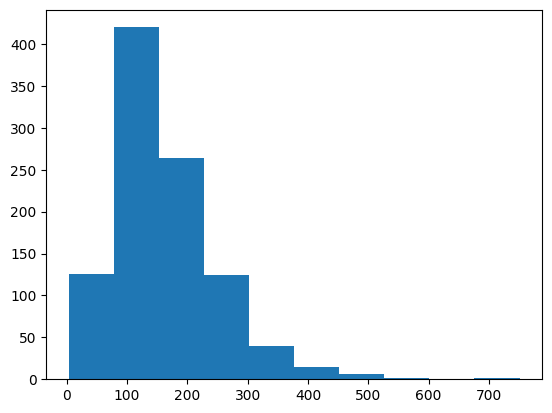

In [46]:
frames_por_seq = data['sequence_id'].value_counts()
promedio_frames = frames_por_seq.mean()
print(f"Promedio de frames por secuencia: {promedio_frames:.2f}")
print(f"Máximo de frames", max(frames_por_seq))
print(f"Mínimo de frames", min(frames_por_seq))

plt.hist(frames_por_seq)

Se puede ver que la mayoría de secuencias tienen frames relativamente bajos. La mayoría de los datos se concentra entre 90 y 150 frames. Luego, mientras más frames, menos secuencias podemos encontrar con esa longitud. Esto indica que la mayoríaa de los videos que vamos a analizar es de longitud pequeña y que en cada parquet hay muchas secuencias. 

In [20]:
SEQ_ID = None              
HAND_PREF = 'auto'         # 'auto' | 'right_hand' | 'left_hand'
DRAW_FACE = True
FPS = 10
INTERVAL_MS = int(1000/FPS)
OUTPUT_GIF = "asl_3d.gif"

SEQ_ID, seq = pick_sequence(data, seq_id=SEQ_ID)
print("Usando SEQ_ID =", SEQ_ID, "frames:", len(seq))

HAND_TO_PLOT = pick_hand(seq, prefer=HAND_PREF)
print("Hand seleccionada (3D):", HAND_TO_PLOT)

parts_for_bounds = ("right_hand","left_hand","pose")+ (("face",) if DRAW_FACE else tuple())
axis_bounds = compute_axis_bounds_3d(seq, parts_for_bounds)

# Animación
fig = plt.figure(figsize=(16,12))
ax_hand = fig.add_subplot(221, projection="3d")
ax_pose = fig.add_subplot(222, projection="3d")
ax_face = fig.add_subplot(223, projection="3d")

def update(frame_idx):
    row = seq.iloc[frame_idx]
    ax_hand.cla(); ax_pose.cla(); ax_face.cla()

    color = "red" if HAND_TO_PLOT == "right_hand" else "blue"
    title = "Right Hand" if HAND_TO_PLOT == "right_hand" else "Left Hand"
    plot_part_3d(ax_hand, row, HAND_TO_PLOT, color, title, axis_bounds)

    plot_part_3d(ax_pose, row, "pose", "orange", "Pose", axis_bounds)

    if DRAW_FACE:
        plot_part_3d(ax_face, row, "face", "green", "Face", axis_bounds)
    else:
        ax_face.set_title("Face (omitida)"); ax_face.set_axis_off()

    fig.suptitle(f"Seq {SEQ_ID} · Frame {frame_idx+1}/{len(seq)}", fontsize=14)

anim = FuncAnimation(fig, update, frames=len(seq), interval=INTERVAL_MS)
anim.save(OUTPUT_GIF, writer=PillowWriter(fps=FPS))
plt.close()
print(f"GIF 3D guardado: {OUTPUT_GIF}")


Usando SEQ_ID = 1975433633 frames: 127
Hand seleccionada (3D): right_hand
GIF 3D guardado: asl_3d.gif


In [21]:
SEQ_ID = None              
HAND_PREF = 'auto'         # 'auto' | 'right_hand' | 'left_hand'
DRAW_FACE = False
MIRROR_X = False           # True para reflejar la mano en X
FPS = 12
INTERVAL_MS = int(1000/FPS)
OUTPUT_GIF = "asl_2d.gif"

SEQ_ID, seq = pick_sequence(data, seq_id=SEQ_ID)
print("Usando SEQ_ID =", SEQ_ID, "frames:", len(seq))

HAND_TO_PLOT = pick_hand(seq, prefer=HAND_PREF)
print("Hand seleccionada (2D):", HAND_TO_PLOT)

parts_for_bounds = ("right_hand","left_hand","pose")+ (("face",) if DRAW_FACE else tuple())
axis_bounds = compute_axis_bounds_2d(seq, parts_for_bounds, mirror_x=MIRROR_X)

# Animación
fig, (ax_hand, ax_pose) = plt.subplots(1, 2, figsize=(12,6))
plt.tight_layout()

def update(frame_idx):
    row = seq.iloc[frame_idx]
    ax_hand.cla(); ax_pose.cla()

    color = "tab:red" if HAND_TO_PLOT == "right_hand" else "tab:blue"
    title = "Right Hand" if HAND_TO_PLOT == "right_hand" else "Left Hand"
    plot_part_2d(ax_hand, row, HAND_TO_PLOT, color, title, mirror_x=MIRROR_X)
    set_limits_2d(ax_hand, axis_bounds, (HAND_TO_PLOT,), invert_y=False)

    plot_part_2d(ax_pose, row, "pose", "tab:orange", "Pose", mirror_x=False)
    if DRAW_FACE:
        plot_part_2d(ax_pose, row, "face", "tab:green", "Face", mirror_x=False)
        set_limits_2d(ax_pose, axis_bounds, ("pose","face"), invert_y=True)
    else:
        set_limits_2d(ax_pose, axis_bounds, ("pose",), invert_y=True)

    fig.suptitle(f"Seq {SEQ_ID} · Frame {frame_idx+1}/{len(seq)}", fontsize=14)

anim = FuncAnimation(fig, update, frames=len(seq), interval=INTERVAL_MS)
anim.save(OUTPUT_GIF, writer=PillowWriter(fps=FPS))
plt.close()
print(f"GIF 2D guardado: {OUTPUT_GIF}")


Usando SEQ_ID = 1975433633 frames: 127
Hand seleccionada (2D): right_hand
GIF 2D guardado: asl_2d.gif
